Executing KMeans I get the following warning:<br>
<br>
UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment <br>variable OMP_NUM_THREADS=2.<br>
<br>
On Stack-Overflow I find the following explanation:<br>
There are more than the 3 mentioned environmental variables. The followings are the complete list of environmental variables and the package that uses that variable to <br>control the number of threads it spawns. Note than you need to set these variables before doing import numpy:<br>
<br>
OMP_NUM_THREADS: openmp,<br>
OPENBLAS_NUM_THREADS: openblas,<br>
MKL_NUM_THREADS: mkl,<br>
VECLIB_MAXIMUM_THREADS: accelerate,<br>
NUMEXPR_NUM_THREADS: numexpr<br>
So in practice you can do:<br>
<br>
import os<br>
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4<br>
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 <br>
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6<br>
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4<br>
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6<br>
Note that as of November 2018 the Numpy developers are working on making this possible to do after you do import numpy as well. I'll update this post once they commit <br>those changes.<br>

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1

In [2]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array([[1, 2, 2], [1, 4, 5], [1, 0, 7], [10, 2,0], [10, 1, 4], [10, 0, 9]])
km = KMeans(n_clusters=2, random_state=0).fit(X)
km.labels_

array([1, 1, 1, 0, 0, 0])

In [3]:
# predict() gives the label of the cluster the instance is asigned to:

km.predict([[0, 0, 0], [5, 12, 3]]) 

array([1, 1])

In [4]:
# the cluster-centers/ centroids the algorithm chose

km.cluster_centers_

array([[10.        ,  1.        ,  4.33333333],
       [ 1.        ,  2.        ,  4.66666667]])

In [5]:
# transform() returns for every instance the distance to each of the centroids, i.e. in our case the distances to two centroids.
# high-dimensional data can thus be transformed/ reduced into k-dimensional data.

km.transform(X)

array([[ 9.35117343,  2.66666667],
       [ 9.51022841,  2.02758751],
       [ 9.43986817,  3.07318149],
       [ 4.44722135, 10.13793755],
       [ 0.33333333,  9.07989231],
       [ 4.77260702, 10.18713786]])

In [6]:
# quality metric for kmeans - "the lower the inertia, the better the model":
km.inertia_

63.33333333333334

In [7]:
from sklearn.metrics import silhouette_score
silhouette_score(X, km.labels_)

0.47628886535580245

In [8]:
from sklearn.metrics import silhouette_samples
sh = silhouette_samples(X, km.labels_)
sh, sh[km.labels_ == 1]

(array([0.55149575, 0.60477922, 0.5125742 , 0.360238  , 0.51209822,
        0.31654779]),
 array([0.55149575, 0.60477922, 0.5125742 ]))

## Number of Centroid Selection with Silhouette-Coefficients ##
Example from (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

In [9]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=8,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

In [10]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

def draw_Silhouette_scores(X,y, cluster_range):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        """ print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        ) """

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for the various clusters.")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("Visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

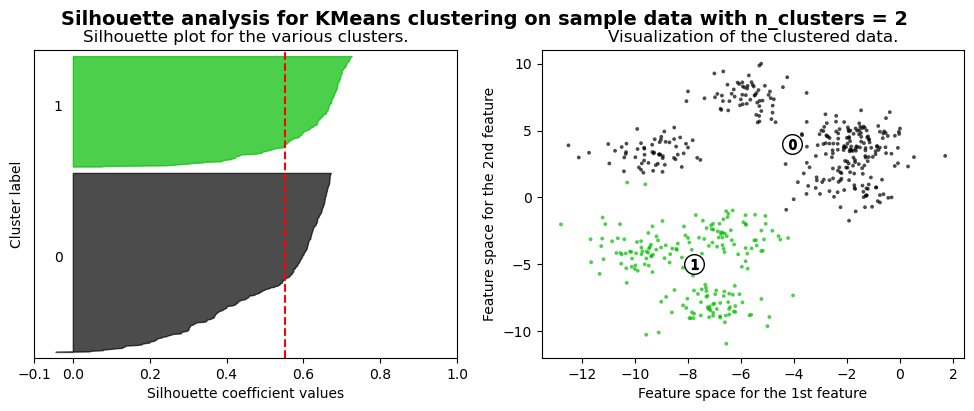

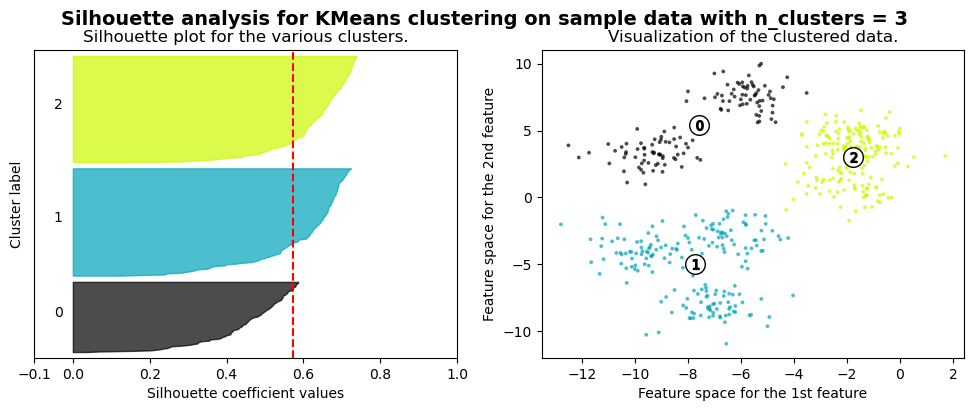

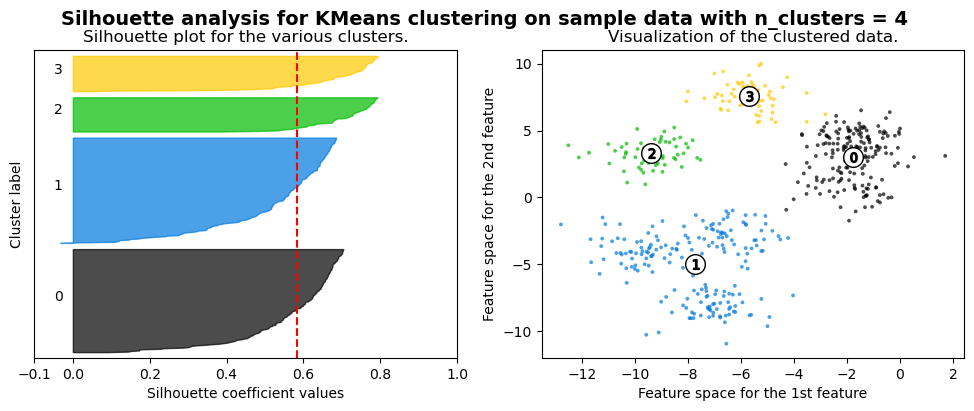

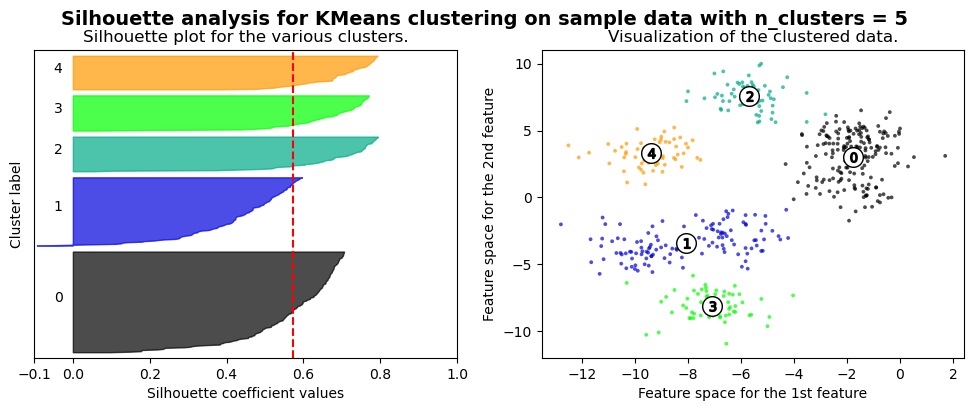

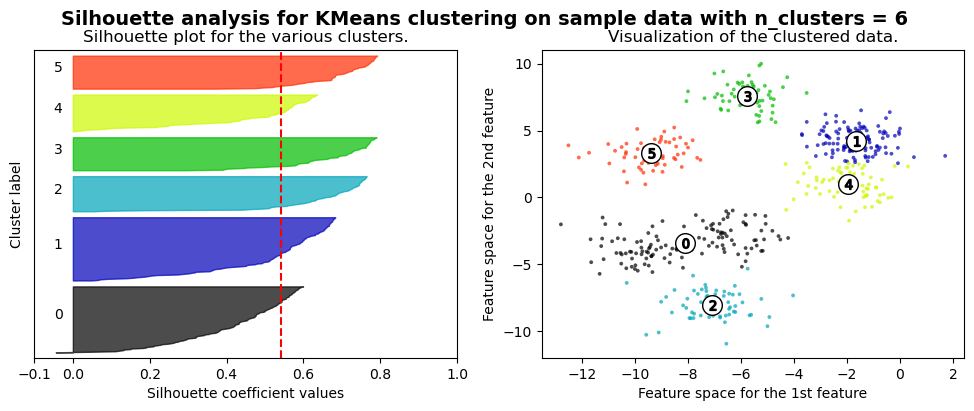

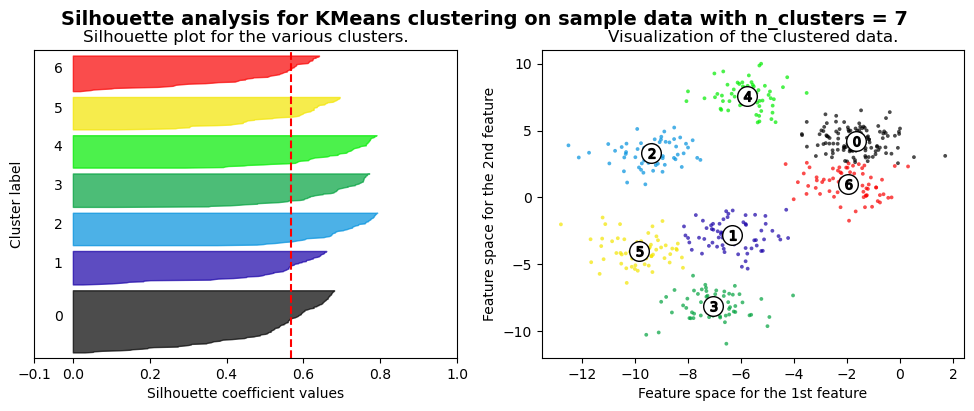

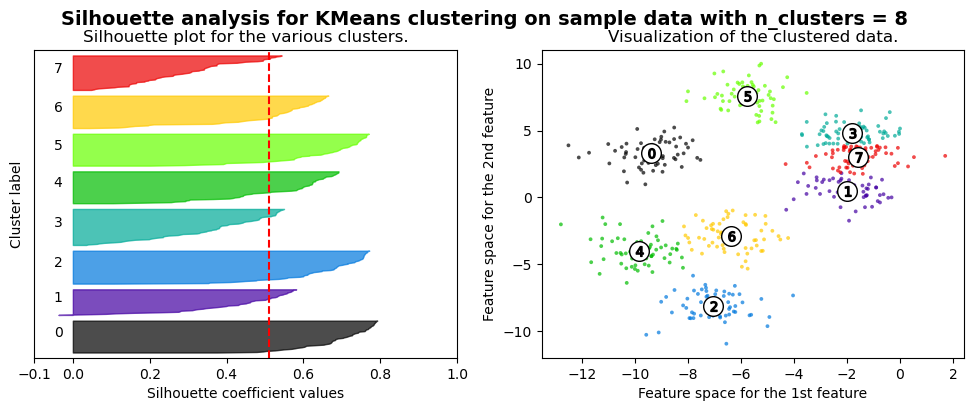

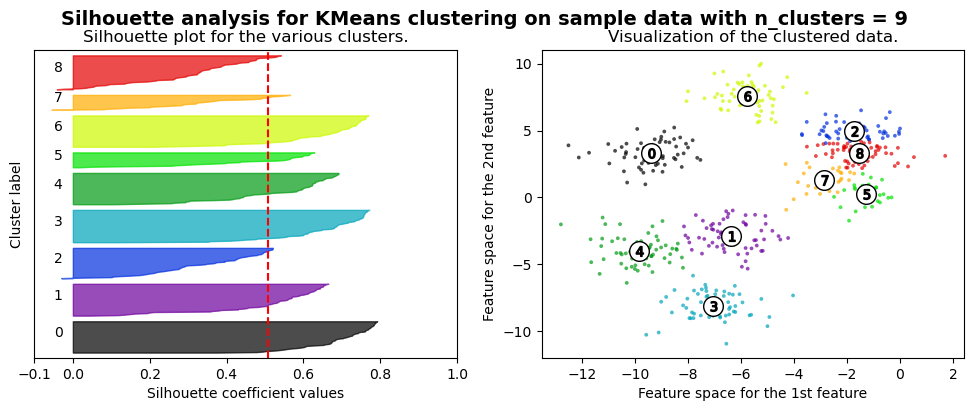

In [11]:
draw_Silhouette_scores(X,y,range_n_clusters)

## Mnist KMeans-Preprocessing ##

In [12]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(f"log_reg.score : {log_reg.score(X_test, y_test):.3f}")

# Result:
# log_reg.score : 0.960

log_reg.score : 0.956


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("kmeans", KMeans()),
    ("log_reg", LogisticRegression())
])

#params = {"kmeans__n_clusters" : range(2,100)}
params = {"kmeans__n_clusters" : range(90, 100)}

logRegKMeans = GridSearchCV(pipe, params, cv=5, verbose=1)
logRegKMeans.fit(X_train, y_train)
print(f"Best params: {logRegKMeans.best_params_}")
print(f"logRegKMeans.score : {logRegKMeans.score(X_test, y_test):.3f}")

# Result:
# Best params: {'kmeans__n_clusters': 97}
# logRegKMeans.score : 0.969

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Best params: {'kmeans__n_clusters': 94}
logRegKMeans.score : 0.962


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Training on only 50 Samples ##
We train on only 50 data-points, which decreases accuray, of course. Then we apply KMeans-Clustering (with k=50), choose the 50 data-points closest to <br>
the centroids (calling them "representative" data-points) and train once more on only these 50 samples. <br>

In [15]:
n_labeled = 50
log_reg = LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

print(f"log_reg.score : {log_reg.score(X_test, y_test):.3f}")

# Result:
# log_reg.score : 0.851

log_reg.score : 0.811


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
k = 50
kmeans = KMeans(n_clusters = k)
X_digits_dist = kmeans.fit_transform(X_train) # Compute clustering and transform X to cluster-distance space.
representative_digit_idx = np.argmin(X_digits_dist, axis = 0) # argmin along each column, i.e. we find for each centroid the closest data-point.
X_representative = X_train[representative_digit_idx]
y_representative = y_train[representative_digit_idx]

In [23]:
print(f"X_digits_dist.shape : {X_digits_dist.shape}") # each data-point is characterized by it's distances to the centroids.
print(f"representative_digit_idx.shape : {representative_digit_idx.shape}")  # for each centroid we have one data-point being closest by.

X_digits_dist.shape : (1347, 50)
representative_digit_idx.shape : (50,)


In [24]:
# train on the representatives:

log_reg = LogisticRegression()
log_reg.fit(X_representative, y_representative)
print(f"log_reg.score : {log_reg.score(X_test, y_test):.3f}")

# Result:
# log_reg.score : 0.907

log_reg.score : 0.927


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Still training with only 50 data-points, but using representative data-points from each cluster improves the score from <br>
log_reg.score : 0.851 <br>
to <br>
log_reg.score : 0.907

## Label Propagation ##
Use the representative labels to label all cluster-members for each cluster according to the representative label.

In [25]:
y_train.shape

(1347,)

In [35]:
y_train_propagated = np.zeros(y_train.shape[0])
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative[i]


In [36]:
# training on the entire train-set with propagated labels:

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train_propagated)
print(f"log_reg.score: {log_reg.score(X_test, y_test):.3f}")

# Result:
# log_reg.score: 0.911

log_reg.score: 0.927


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training with labels propagated from a cluster analysis with KMeans, i.e. from 50 possibly manually assigned label gives us a score of 0.911.
Our best result from gridsearch over n_clusters was: 0.969

Next - calculate the percentage of propagated labels that coincide with the original labels:

In [37]:
np.mean(y_train_propagated == y_train)

0.9458054936896808

## Percentile Propagation ##
Propagate labels only to the data-points closest to the centroids - the closest p percent.

In [32]:
X_digits_dist.shape

(1347, 50)

In [33]:
percentile_closest = 20

X_Cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_Cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_Cluster_dist > cutoff_distance)
    X_Cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_Cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

How many instances do we have within the closest percentile?

In [39]:
X_train_partially_propagated.shape, y_train_partially_propagated.shape

((288, 64), (288,))

In [41]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
print(f"log_reg.score : {log_reg.score(X_test, y_test):.3f}")

# Result:
# log_reg.score : 0.933

log_reg.score : 0.933


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Next - calculate the percentage of the paritally-propagated labels coinciding with the actual labels:

In [38]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

1.0